In [1]:
import sys

sys.path.append('./../NeuroDataResource/')

import pickle
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from NeuroDataResource import NeuroDataResource

token = pickle.load(open('./../NeuroDataResource/data/token.pkl', 'rb'))

In [2]:
myResource = NeuroDataResource(host = 'api.boss.neurodata.io',
                               token = token,
                               collection = 'collman',
                               experiment = 'collman15v2',
                               chanList = [{'name': 'annotation', 'dtype': 'uint64'},
                                           {'name': 'DAPI1st', 'dtype':'uint8'},
                                           {'name': 'DAPI2nd', 'dtype':'uint8'},
                                           {'name': 'DAPI3rd', 'dtype':'uint8'},
                                           {'name': 'EM25K', 'dtype':'uint8'},
                                           {'name': 'GABA488', 'dtype':'uint8'},
                                           {'name': 'GAD647', 'dtype':'uint8'},
                                           {'name': 'gephyrin594', 'dtype':'uint8'},
                                           {'name': 'GS594', 'dtype':'uint8'},
                                           {'name': 'MBP488', 'dtype':'uint8'},
                                           {'name': 'NR1594', 'dtype':'uint8'},
                                           {'name': 'PSD95_488', 'dtype':'uint8'},
                                           {'name': 'Synapsin647', 'dtype':'uint8'},
                                           {'name': 'VGluT1_647', 'dtype':'uint8'}
                                          ])

In [3]:
cutouts = {}
for key in myResource._chanList.keys():
    if not 'EM' in key:
        print(key)
        cutout = myResource.get_cutout(chan=key, zRange=[5, 15], yRange=[1000, 2000], xRange=[1000, 2500])
        cutouts[key] = cutout

VGluT1_647
GS594
DAPI3rd
annotation
gephyrin594
GABA488
MBP488
Synapsin647
DAPI2nd
GAD647
PSD95_488
NR1594
DAPI1st


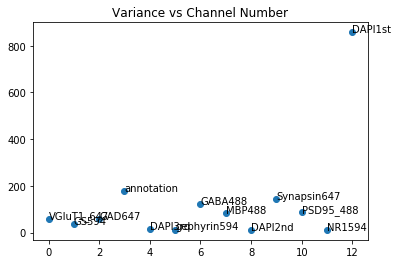

In [34]:
plt.figure()
fig, ax = plt.subplots()
plt.title('Variance vs Channel Number')
x = [i for i in range(len(cutouts.keys()))]
y = [np.var(volume) for volume in cutouts.values()]
plt.scatter(x, y)
for i, text in enumerate(cutouts.keys()):
    ax.annotate(text, (x[i], y[i]))
plt.show()

This explains why the PCA breakdown looked so much like DAPI...
Let's try the analysis without the DAPI channels

In [35]:
ledger = []
chans = []
for key, value in cutouts.items():
    if not 'annotation' in key and not 'DAPI' in key:
        ledger.append(key)
        chans.append(value)
    
volume = np.stack(chans)
print(volume.shape)

(9, 10, 1000, 1500)


In [36]:
volume = np.moveaxis(volume, 0, -1).reshape([-1, 9])
volume.shape

(15000000, 9)

In [37]:
NMF_model = NMF(n_components=2, init='nndsvdar', solver='mu', max_iter=10000)
NMF_model = NMF_model.fit(volume)

In [38]:
out = NMF_model.transform(volume)

In [39]:
out = out.reshape(10, 1000, 1500, 2)

In [40]:
np.var(volume)

115.21264048445762

In [42]:
np.var(NMF_model.inverse_transform(out))

72.304953456547423

In [47]:
variances = []
for i in range(1, 5):
    print(i)
    NMF_model = NMF(n_components=i, init='nndsvdar', solver='mu', max_iter=10000)
    NMF_model = NMF_model.fit(volume)
    out = NMF_model.transform(volume)
    out = out.reshape(10, 1000, 1500, i)
    variances.append(np.var(NMF_model.inverse_transform(out)))

1
2
3
4


In [57]:
NMF_model = NMF(n_components=5, init='nndsvdar', solver='mu', max_iter=10000)
NMF_model = NMF_model.fit(volume)
out = NMF_model.transform(volume)
out = out.reshape(10, 1000, 1500, 5)
variances.append(np.var(NMF_model.inverse_transform(out)))

In [59]:
NMF_model = NMF(n_components=6, init='nndsvdar', solver='mu', max_iter=10000)
NMF_model = NMF_model.fit(volume)
out = NMF_model.transform(volume)
out = out.reshape(10, 1000, 1500, 6)
variances.append(np.var(NMF_model.inverse_transform(out)))

In [62]:
NMF_model = NMF(n_components=7, init='nndsvdar', solver='mu', max_iter=10000)
NMF_model = NMF_model.fit(volume)
out = NMF_model.transform(volume)
out = out.reshape(10, 1000, 1500, 7)
variances.append(np.var(NMF_model.inverse_transform(out)))

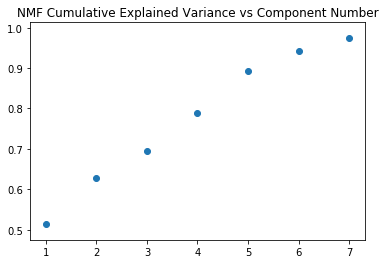

In [63]:
plt.figure()
plt.title('NMF Cumulative Explained Variance vs Component Number')
plt.scatter([i+1 for i in range(len(variances))], np.array(variances)/np.var(volume))
plt.show()

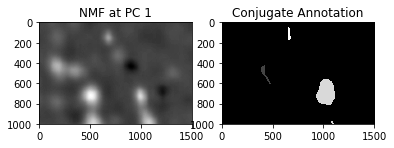

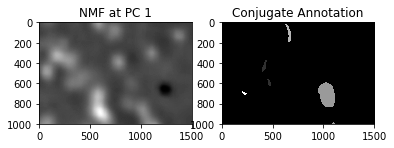

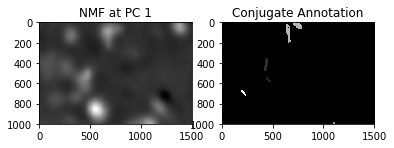

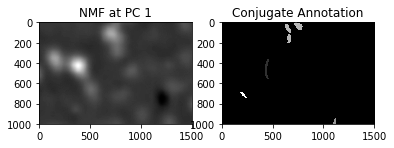

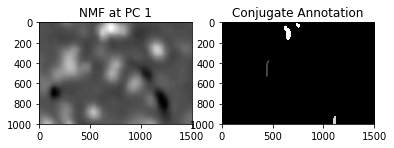

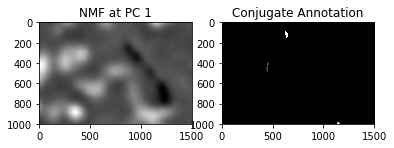

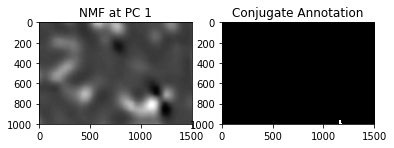

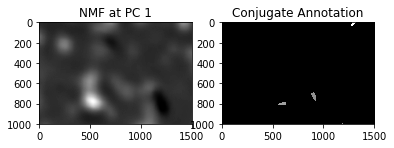

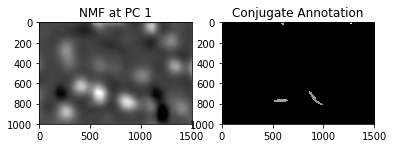

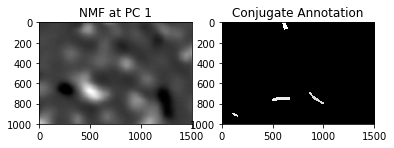

In [10]:
plt.figure()
for i in range(10):
    plt.subplot(121)
    plt.title('NMF at PC 1')
    plt.imshow(out[i, :, :, 0], cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

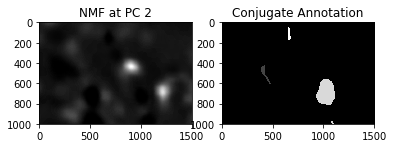

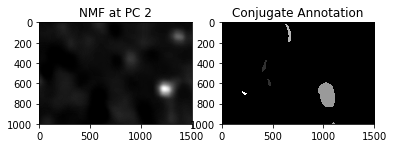

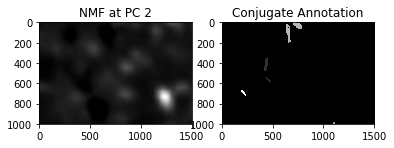

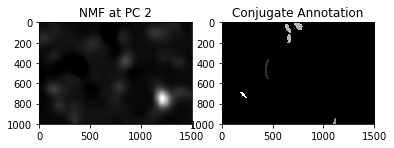

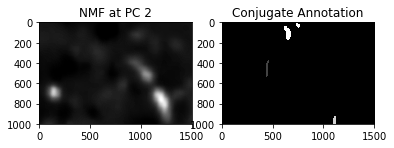

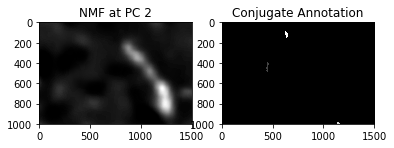

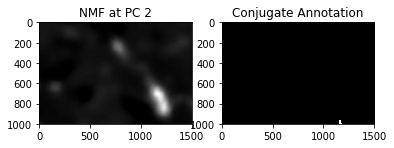

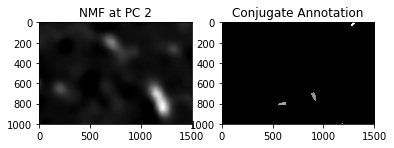

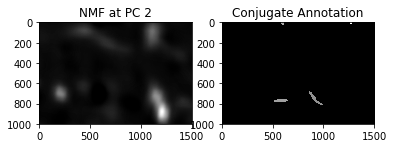

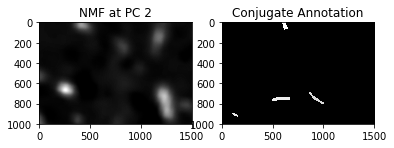

In [11]:
plt.figure()
for i in range(10):
    plt.subplot(121)
    plt.title('NMF at PC 2')
    plt.imshow(out[i, :, :, 1], cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

In [12]:
positive = out[cutouts['annotation'] > 0]
negative = out[cutouts['annotation'] == 0]

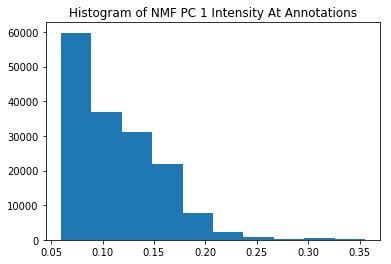

In [13]:
plt.figure()
plt.title('Histogram of NMF PC 1 Intensity At Annotations')
plt.hist(positive[:,0].flatten())
plt.show()

(161294,)


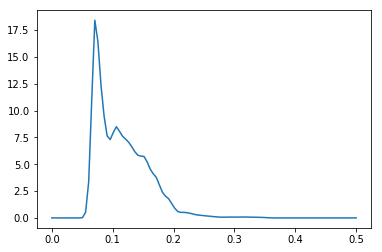

In [14]:
from scipy.stats import gaussian_kde
print(positive[:, 0].shape)
density = gaussian_kde(positive[:, 0])
xs = np.linspace(0, .5, 100)
plt.plot(xs, density(xs))
plt.show()

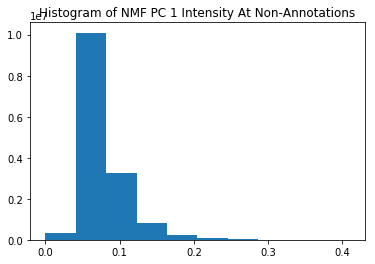

In [15]:
plt.figure()
plt.title('Histogram of NMF PC 1 Intensity At Non-Annotations')
plt.hist(negative[:,0].flatten())
plt.show()

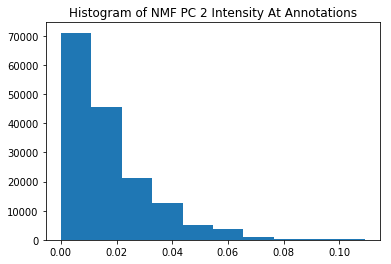

In [16]:
plt.figure()
plt.title('Histogram of NMF PC 2 Intensity At Annotations')
plt.hist(positive[:,1].flatten())
plt.show()

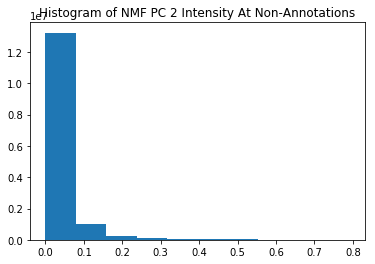

In [17]:
plt.figure()
plt.title('Histogram of NMF PC 2 Intensity At Non-Annotations')
plt.hist(negative[:,1].flatten())
plt.show()

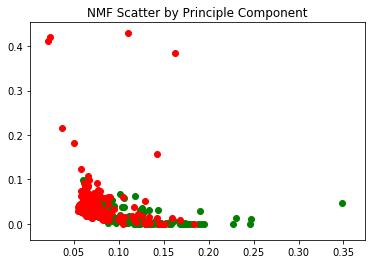

In [18]:
plt.figure()
plt.title('NMF Scatter by Principle Component')
plt.scatter([positive[i][0] for i in range(0, positive.shape[0], 1000)], [positive[i][1] for i in range(0, positive.shape[0], 1000)], c='g')
plt.scatter([negative[i][0] for i in range(0, negative.shape[0], 100000)], [negative[i][1] for i in range(0, negative.shape[0], 100000)], c='r')
plt.show()

In [19]:
PCA_model = PCA()
PCA_model = PCA_model.fit(volume)
out_PCA = PCA_model.transform(volume)

In [20]:
out_PCA = out_PCA.reshape(10, 1000, 1500, 9)

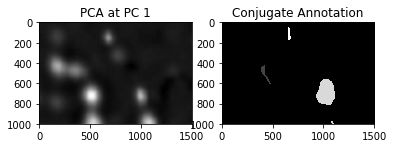

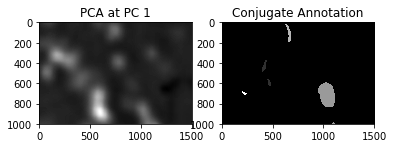

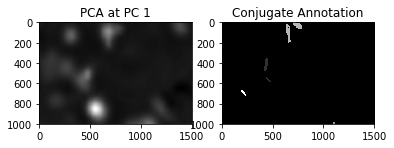

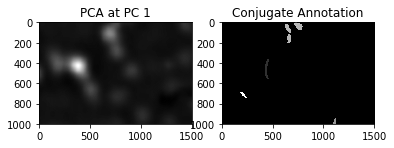

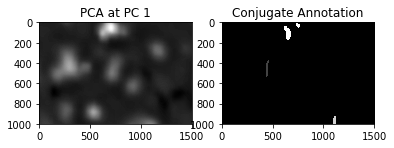

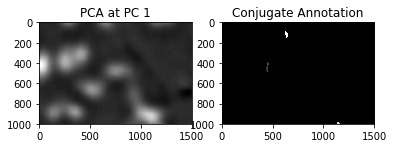

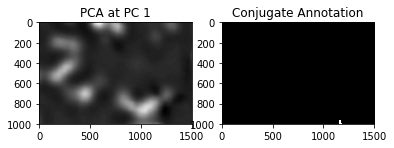

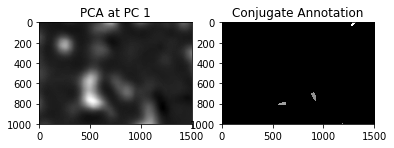

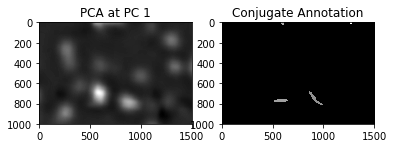

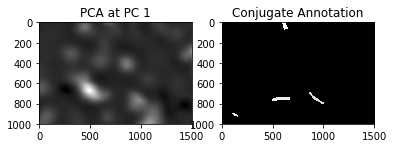

In [21]:
plt.figure()
for i in range(10):
    plt.subplot(121)
    plt.title('PCA at PC 1')
    plt.imshow(out_PCA[i, :, :, 0], cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

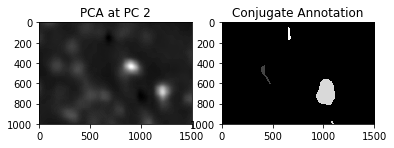

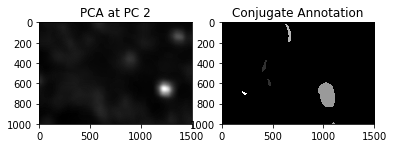

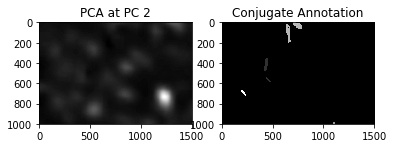

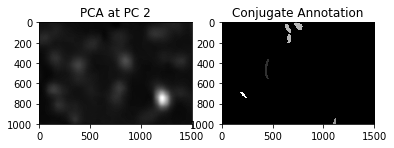

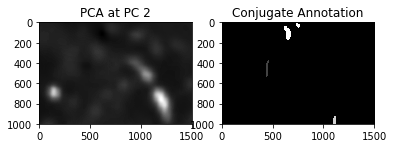

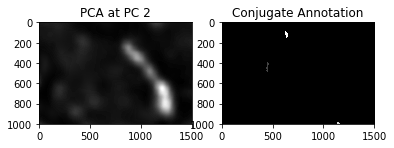

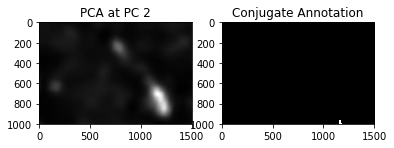

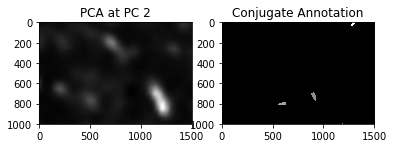

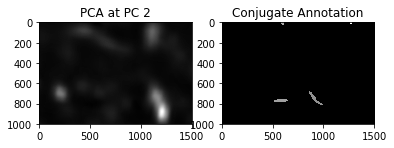

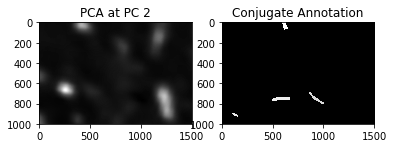

In [22]:
plt.figure()
for i in range(10):
    plt.subplot(121)
    plt.title('PCA at PC 2')
    plt.imshow(out_PCA[i, :, :, 1], cmap='gray')
    plt.subplot(122)
    plt.title('Conjugate Annotation')
    plt.imshow(cutouts['annotation'][i, :, :], cmap='gray')
    plt.show()

In [23]:
positive = out_PCA[cutouts['annotation'] > 0]
negative = out_PCA[cutouts['annotation'] == 0]

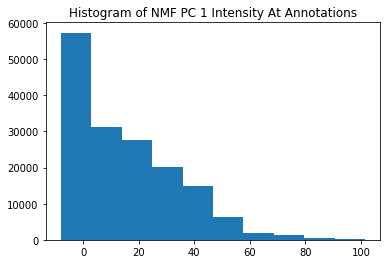

In [24]:
plt.figure()
plt.title('Histogram of NMF PC 1 Intensity At Annotations')
plt.hist(positive[:,0].flatten())
plt.show()

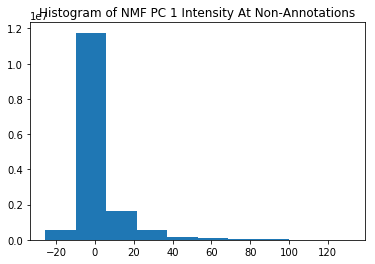

In [25]:
plt.figure()
plt.title('Histogram of NMF PC 1 Intensity At Non-Annotations')
plt.hist(negative[:,0].flatten())
plt.show()

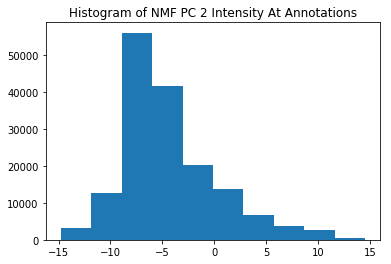

In [26]:
plt.figure()
plt.title('Histogram of NMF PC 2 Intensity At Annotations')
plt.hist(positive[:,1].flatten())
plt.show()

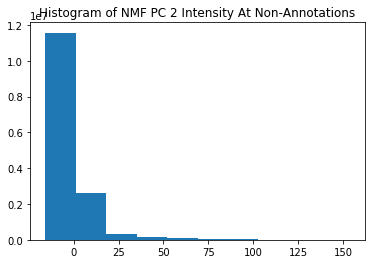

In [27]:
plt.figure()
plt.title('Histogram of NMF PC 2 Intensity At Non-Annotations')
plt.hist(negative[:,1].flatten())
plt.show()

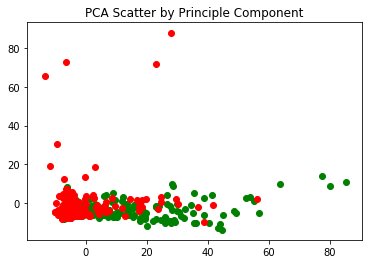

In [28]:
plt.figure()
plt.title('PCA Scatter by Principle Component')
plt.scatter([positive[i][0] for i in range(0, positive.shape[0], 1000)], [positive[i][1] for i in range(0, positive.shape[0], 1000)], c='g')
plt.scatter([negative[i][0] for i in range(0, negative.shape[0], 100000)], [negative[i][1] for i in range(0, negative.shape[0], 100000)], c='r')
plt.show()

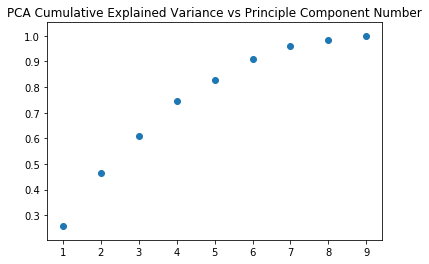

In [33]:
PCA_model.explained_variance_
plt.figure()
plt.title('PCA Cumulative Explained Variance vs Principle Component Number')
plt.scatter([i+1 for i in range(len(PCA_model.explained_variance_))], np.cumsum([PCA_model.explained_variance_])/np.sum(PCA_model.explained_variance_))
plt.show()

Here things are starting to look better. It also seems like PCA is consistently outperforming NMF, so I'm going to stick with that for the rest of this analysis